<center><img src="https://raw.githubusercontent.com/chiapas/kaggle/master/competitions/contradictory-my-dear-watson/header.png" width="1000"></center>
<br>
<center><h1>Visualize Bert's token masking</h1></center>
<br>

#### In this notebook, we implement and visualize token masking in Masked Language Model (MLM), which is used for training [Bert model](https://arxiv.org/pdf/1810.04805.pdf) and [(XLM)-Roberta model](https://arxiv.org/pdf/1907.11692.pdf). The implemention is a translation into [TensorFlow](https://www.tensorflow.org/) from [Hugging Face](https://github.com/huggingface/transformers/blob/390c1285925dd119705e69a266202ef04490d012/examples/distillation/distiller.py)'s code, which is originally in [PyTorch](https://pytorch.org/). We also visualize the effects of token masking.

#### Here are some features of the implementation:
  * <p style="color:blue">dynamic token masking in TensorFlow operations, therefore it could be used as a tf.data.Dataset transformation.</p>
  * <p style="color:blue">the number of tokens to mask is calculated based on non-padding tokens (and optionally, excluding other special tokens)</p>
  * <p style="color:blue">including a smoothing option to mask rare tokens more frequently</p>
  
This notebook is a simplified version of another notebook [Masked, My Dear Watson - MLM with TPU](https://www.kaggle.com/yihdarshieh/masked-my-dear-watson-mlm-with-tpu), where you can find how to use token masking to fine tune models with MLM objective, and a comparision between without and with using MLM finetuning.

# Preview token masking in Masked Language Models (MLM)

#### Here is how a masked batch of tokens looks like:

It consists:
* tokens not to predict
  1. word tokens: green
  2. (optional) special tokens: green (we can choose to predict or not speical tokens like `[CLS]` or `[SEP]`, etc.)
  3. padding tokens: blue
* tokens to predict:
  1. the token is masked: gray
  2. the token is kept as it is: yellow
  3. the token is replaced by a random tokens in the vocabulary: pink

Here we use a higher masking frequency (`0.35`), so you may find that too many tokens are masked for training MLM. This is only for visualization. In the experiment, we will use a frequency of `0.15`, which is used for traininig [Bert](https://arxiv.org/pdf/1810.04805.pdf).

To visualize (in an interactive way) a real batch of masked tokens used for training, see [Visualize a batch of MLM finetuning dataset](#check-mlm-fine-tuning-batch). The tokens are not displayed directly, but you can hover the grid to see the token information.

### 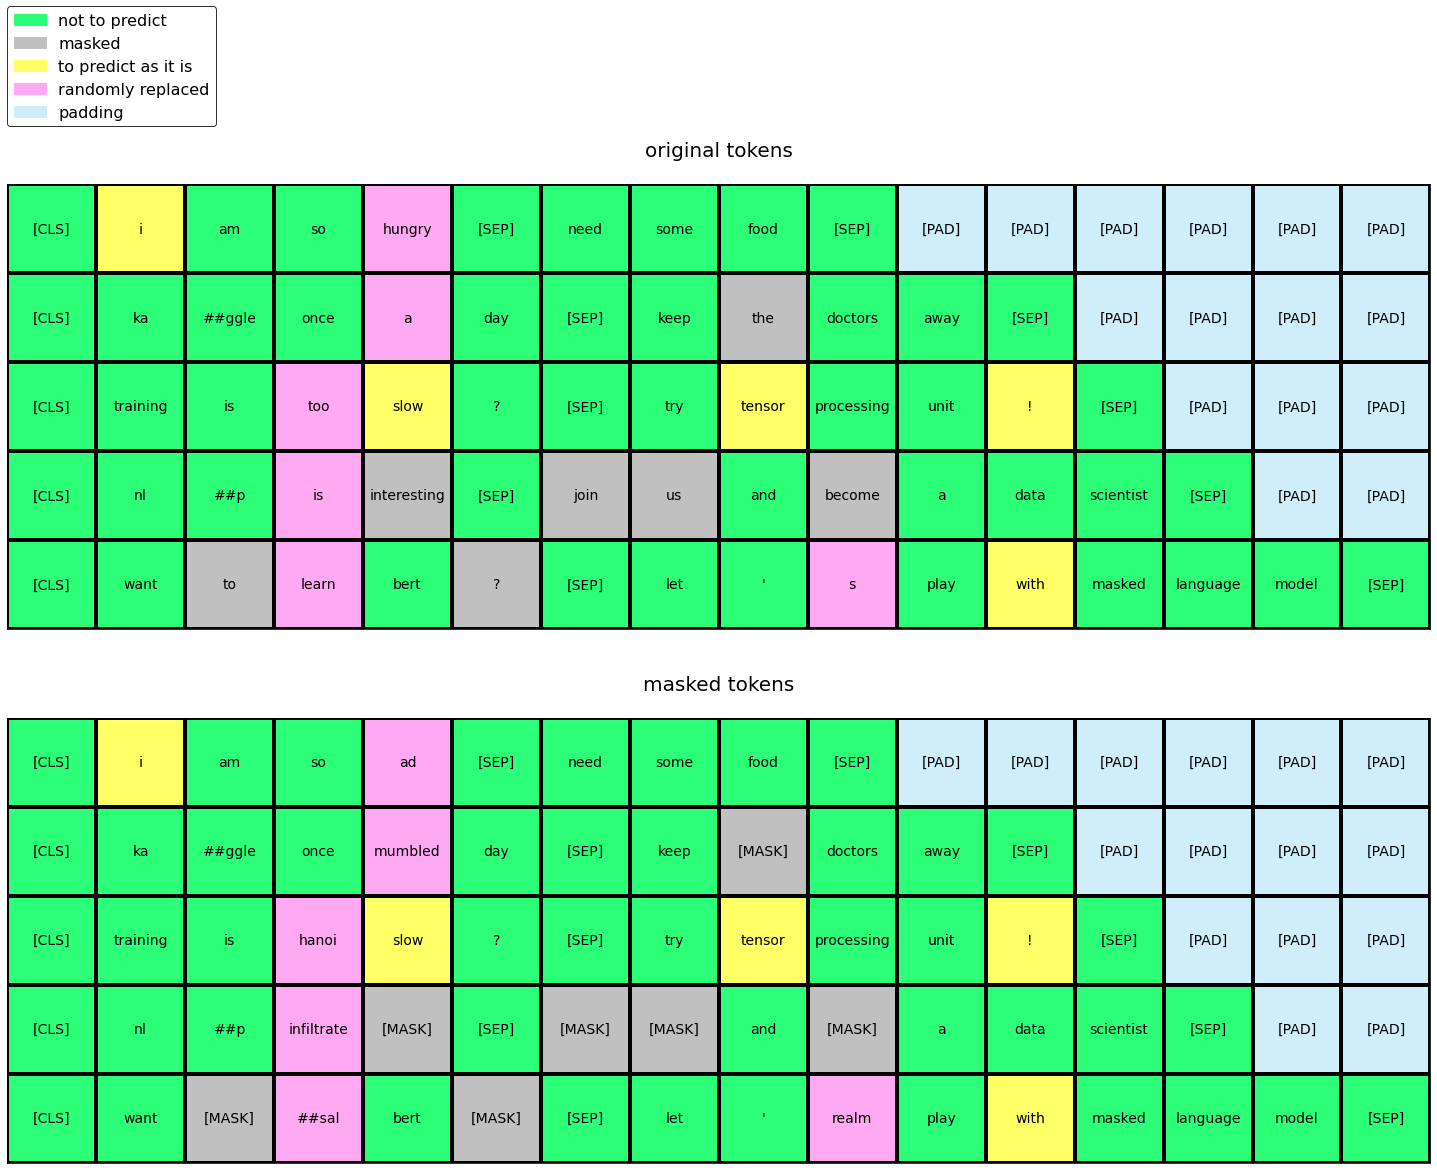

#### Import

In [ ]:
import os
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

import numpy as np
import random
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
!pip install --upgrade kaleido
import kaleido

!pip uninstall -y transformers
!pip install transformers

import transformers
import tokenizers
import transformers
import tokenizers

import datetime
import json
import IPython
from collections import Counter
from IPython.display import display, HTML, IFrame

# Masked Language Model<a id='mlm'></a>

## Implementation of masking tokens<a id='imp-mlm'></a>

### Sample without replacement in TensorFlow<a id='sample-no-replacement'></a>

In PyTorch, we can use

```
    torch.multinomial(..., replacement=False)
```

to perform sampling without replacement. In TensorFlow, there is no direct API to perform this operation.

Following the discussion [here on GitHub](https://github.com/tensorflow/tensorflow/issues/9260#issuecomment-437875125),
we use the [Gumbel-max trick]( https://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) to implement it.

In [ ]:
def sample_without_replacement(prob_dist, nb_samples):
    """Sample integers in the range [0, N), without replacement, according to the probability
       distribution `prob_dist`, where `N = prob_dist.shape[0]`.
    
    Args:
        prob_dist: 1-D tf.float32 tensor.
    
    Returns:
        selected_indices: 1-D tf.int32 tensor
    """

    nb_candidates = tf.shape(prob_dist)[0]
    logits = tf.math.log(prob_dist)
    z = -tf.math.log(-tf.math.log(tf.random.uniform(shape=[nb_candidates], minval=0, maxval=1)))
    _, selected_indices = tf.math.top_k(logits + z, nb_samples)

    return selected_indices

#### Sanity check

In [ ]:
for i in range(10):
    print('sample {}: {}'.format(i + 1, sample_without_replacement(tf.constant([0.1, 0.2, 0.3, 0.4]), nb_samples=3).numpy()))

### Mask tokens<a id='mask-tokens'></a>

#### This is the main method that peforms token masking for training MLM language models. It is a translation into [TensorFlow](https://www.tensorflow.org/) from [Hugging Face](https://github.com/huggingface/transformers/blob/390c1285925dd119705e69a266202ef04490d012/examples/distillation/distiller.py)'s code, which is originally in [PyTorch](https://pytorch.org/).

The `mlm_smoothing` argument is used to emphasize more rare tokens, see [Cross-lingual Language Model Pretraining (XLM)](https://arxiv.org/pdf/1901.07291.pdf). If `token_counts` is `None`, it will be a uniform distribution over the vocabulary, except for some special tokens.

In [ ]:
def get_masked_lm_fn(tokenizer, mlm_mask_prob=0.15, mask_type_probs=(0.8, 0.1, 0.1), token_counts=None, predict_special_tokens=False, mlm_smoothing=0.7):
    """
    Prepare the batch: from the input_ids and the lenghts, compute the attention mask and the masked label for MLM.

    Args:

        tokenizer: A Hugging Face tokenizer.  
        
        token_counts: A list of integers of length `tokenizer.vocab_size`, which is the token counting in a dataset
            (usually, the huge dataset used for pretraing a LM model). This is used for giving higher probability
            for rare tokens to be masked for prediction. If `None`, each token has the same probability to be masked.

        mlm_mask_prob:  A `tf.float32` scalar tensor. The probability to <mask> a token, inclding
            actually masking, keep it as it is (but to predict it), and randomly replaced by another token.
        
        mask_type_probs: A `tf.float32` tensor of shape [3]. Among the sampled tokens to be <masked>, 

            mask_type_probs[0]: the proportion to be replaced by the mask token
            mask_type_probs[1]: the proportion to be kept as it it
            mask_type_probs[2]: the proportion to be replaced by a random token in the tokenizer's vocabulary
        
        predict_special_tokens: bool, if to mask special tokens, like cls, sep or padding tokens. Default: `False`
        
        mlm_smoothing: float, smoothing parameter to emphasize more rare tokens (see `XLM` paper, similar to word2vec).
        
    Retruns:

        prepare_masked_lm_batch: a function that masks a batch of token sequences.
    """

    if token_counts is None:
        """
        Each token has the same probability to be masked.
        """
        token_counts = [1] * tokenizer.vocab_size

    # Tokens with higher counts will be masked less often.
    # If some token has count 1, it will have freq 1.0 in this frequency list, which is the highest value.
    # However, since it never appears in the corpus used for pretraining, there is no effect of this high frequency.
    token_mask_freq = np.maximum(token_counts, 1) ** -mlm_smoothing

    # NEVER to mask/predict padding tokens.
    token_mask_freq[tokenizer.pad_token_id] = 0.0
    
    if not predict_special_tokens:
        for special_token_id in tokenizer.all_special_ids:
            """
            Do not to predict special tokens, e.g. padding, cls, sep and mask tokens, etc.
            """
            token_mask_freq[special_token_id] = 0.0

    # Convert to tensor.
    token_mask_freq = tf.constant(token_mask_freq, dtype=tf.float32)        

    mlm_mask_prob = tf.constant(mlm_mask_prob)
    mask_type_probs = tf.constant(mask_type_probs)
    
    vocab_size = tf.constant(tokenizer.vocab_size)
    pad_token_id = tf.constant(tokenizer.pad_token_id)
    mask_token_id = tf.constant(tokenizer.mask_token_id)
    
    def prepare_masked_lm_batch(inputs):
        """
        Prepare the batch: from the input_ids and the lenghts, compute the attention mask and the masked label for MLM.

        Args:
            
            inputs: a dictionary of tensors. Format is:
            
                {
                    'input_ids': `tf.int32` tensor of shape [batch_size, seq_len] 
                    : `tf.int32` tensor of shape [batch_size, seq_len] 
                }            
                
                Optionally, it could contain extra keys 'attention_mask' and `token_type_ids` with values being
                `tf.int32` tensors of shape [batch_size, seq_len] 
             
        Returns:
        
            result: a dictionary. Format is as following:

                {
                    'inputs': A dictionary of tensors, the same format as the argument `inputs`.
                    'mlm_labels': shape [batch_size, seq_len]
                    'mask_types': shape [batch_size, seq_len]
                    'original_input_ids': shape [batch_size, seq_len]
                    'nb_tokens': shape [batch_size]
                    'nb_non_padding_tokens': shape [batch_size]
                    'nb_tokens_considered': shape [batch_size]
                    'nb_tokens_masked': shape [batch_size]
                }
                
                The tensors associated to `number of tokens` are the toekn countings in the whole batch, not
                in individual examples. They are actually constants, but reshapped to [batch_size], because
                `tf.data.Dataset` requires the batch dimension to be consistent. These are used only for debugging,
                except 'nb_tokens_masked, which is used for calculating the MLM loss values.
        """

        input_ids = inputs['input_ids']
        
        batch_size, seq_len = input_ids.shape

        attention_mask = None
        if 'attention_mask' in inputs:
            attention_mask = inputs['attention_mask']

        # Compute `attention_mask` if necessary
        if attention_mask is None:
            attention_mask = tf.cast(input_ids != pad_token_id, tf.int32)            

        # The number of tokens in each example, excluding the padding tokens. 
        # shape = [batch_size]
        lengths = tf.reduce_sum(attention_mask, axis=-1)
                
        # The total number of tokens, excluding the padding tokens.
        nb_non_padding_tokens = tf.math.reduce_sum(lengths)

        # For each token in the batch, get its frequency to be masked from the 1-D tensor `token_mask_freq`.
        # We keep the output to remain 1-D, since it's easier for using sampling method `sample_without_replacement`.
        # shape = [batch_size * seq_len], 1-D tensor.
        freq_to_mask = tf.gather(params=token_mask_freq, indices=tf.reshape(input_ids, [-1]))

        # Normalize the frequency to get a probability (of being masked) distribution over tokens in the batch.
        # shape = [batch_size * seq_len], 1-D tensor.
        prob_to_mask = freq_to_mask / tf.reduce_sum(freq_to_mask)

        tokens_considered = tf.cast(attention_mask, tf.bool)
        if not predict_special_tokens:
            for special_token_id in tokenizer.all_special_ids:
                tokens_considered = tf.logical_and(tokens_considered, input_ids != special_token_id)
        nb_tokens_considered = tf.reduce_sum(tf.cast(tokens_considered, dtype=tf.int32))
        
        # The number of tokens to be masked.
        # type = tf.float32
        # nb_tokens_to_mask = tf.math.ceil(mlm_mask_prob * tf.cast(nb_non_padding_tokens, dtype=tf.float32))
        nb_tokens_to_mask = tf.math.ceil(mlm_mask_prob * tf.cast(nb_tokens_considered, dtype=tf.float32))
        
        # round to an integer
        nb_tokens_to_mask = tf.cast(nb_tokens_to_mask, tf.int32)

        # Sample `nb_tokens_to_mask` of different indices in the range [0, batch_size * seq_len).
        # The sampling is according to the probability distribution `prob_to_mask`, without replacement.
        # shape = [nb_tokens_to_mask]
        indices_to_mask = sample_without_replacement(prob_to_mask, nb_tokens_to_mask)
 
        # Create a tensor of shape [batch_size * seq_len].
        # At the indices specified in `indices_to_mask`, it has value 1. Otherwise, the value is 0.
        # This is a mask (after being reshaped to 2D tensor) for masking/prediction, where `1` means that, at that place,
        # the token should be masked for prediction. 
        # (For `tf.scatter_nd`, check https://www.tensorflow.org/api_docs/python/tf/scatter_nd)
        pred_mask = tf.scatter_nd(
            indices=indices_to_mask[:, tf.newaxis],  # This is necessary for making `tf.scatter_nd` work here. Check the documentation.
            updates=tf.cast(tf.ones_like(indices_to_mask), tf.bool),
            shape=[batch_size * seq_len]
        )

        # Change to 2-D tensor.
        # The mask for masking/prediction.
        # shape = [batch_size, seq_len]
        pred_mask = tf.reshape(pred_mask, [batch_size, seq_len])

        # Get token ids at the places where to mask tokens.
        # 1-D tensor, shape = [nb_tokens_to_mask].
        _input_ids_real = input_ids[pred_mask]

        # randomly select token ids from the range [0, vocab_size)
        # 1-D tensor, shape = [nb_tokens_to_mask]
        _input_ids_rand = tf.random.uniform(shape=[nb_tokens_to_mask], minval=0, maxval=vocab_size, dtype=tf.int32)

        # A constant tensor with value `mask_token_id`.
        # 1-D tensor, shape = [nb_tokens_to_mask]
        _input_ids_mask = mask_token_id * tf.ones_like(_input_ids_real, dtype=tf.int32)

        # For each token to be masked, we decide which type of transformations to apply:
        #     0: masked, 1: keep it as it is, 2: replaced by a random token
        
        # Detail: we need to pass log probability (logits) to `tf.random.categorical`,
        #    and it has to be 2-D. The output is also 2-D, and we just take the 1st row.
        # shape = [nb_tokens_to_mask]
        mask_types = tf.random.categorical(logits=tf.math.log([mask_type_probs]), num_samples=nb_tokens_to_mask)[0]

        # These are token ids after applying masking.
        # shape = [nb_tokens_to_mask]
        masked_input_ids = (
            _input_ids_mask * tf.cast(mask_types == 0, dtype=tf.int32) + \
            _input_ids_real * tf.cast(mask_types == 1, dtype=tf.int32) + \
            _input_ids_rand * tf.cast(mask_types == 2, dtype=tf.int32)
        )

        # Put the masked token ids into a 2-D tensor (initially zeros) of shape [batch_size, seq_len].
        # remark: `tf.where(pred_mask)` is of shape [nb_tokens_to_mask, 2].
        token_ids_to_updates = tf.scatter_nd(indices=tf.where(pred_mask), updates=masked_input_ids, shape=[batch_size, seq_len])

        # At the places where we don't mask, just keep the original token ids.
        # shape = [batch_size, seq_len]
        token_ids_to_keep = input_ids * tf.cast(~pred_mask, tf.int32)
        
        # The final masked token ids used for training
        # shape = [batch_size, seq_len]
        masked_input_ids = token_ids_to_updates + token_ids_to_keep
        
        # At the places where we don't predict, change the labels to -100
        # shape = [batch_size, seq_len]
        mlm_labels = input_ids * tf.cast(pred_mask, dtype=tf.int32) + -100 * tf.cast(~pred_mask, tf.int32)

        masked_lm_batch = {
            'input_ids': masked_input_ids,
            'attention_mask': attention_mask
        }
        if 'token_type_ids' in inputs:
            masked_lm_batch['token_type_ids'] = inputs['token_type_ids']

        # The total number of tokens
        nb_tokens = tf.reduce_sum(tf.cast(input_ids > -1, dtype=tf.int32))

        # Used for visualization
        # 0: not masked, 1: masked, 2: keep it as it is, 3: replaced by a random token, 4: padding - (not masked)
        # shape = [batch_size, seq_len]
        _mask_types = tf.scatter_nd(tf.where(pred_mask), updates=mask_types + 1, shape=[batch_size, seq_len])
        _mask_types = tf.cast(_mask_types, dtype=tf.int32)
        _mask_types += 4 * tf.cast(input_ids == pad_token_id, tf.int32)

        result = {
            'inputs': masked_lm_batch,
            'mlm_labels': mlm_labels,
            'mask_types': _mask_types,
            'original_input_ids': input_ids   
        }

        return result

    return prepare_masked_lm_batch

## Visualize mask language model<a id='visualize-mlm'></a>

#### Let's visualize MLM with a simple example!

### Create dummy examples

In [ ]:
dummy_sentence_pairs = [
    ('i am so hungry', 'need some food'),
    ('kaggle once a day', 'keep the doctors away'),
    ('training is too slow?', 'try tensor processing unit!'),
    ('nlp is interesting', 'join us and become a data scientist'),
    ('want to learn bert?', 'let\'s play with masked language model')
]

### Visualization helpers

In [ ]:
colors = np.array(
    [
        [ 44, 255, 119],   # green - unchanged tokens        
        [192, 192, 192],  #  gray - masked tokens
        [255, 255, 102],  # yellow - kept as it is, but to predict        
        [255, 169, 242],  #  pink - randomly replaced tokens
        # [137 ,209, 254 ],  #  blue - padding - unchanged tokens
        [207, 238, 250 ],  #  blue - padding - unchanged tokens
    ]) / 255
cmap = matplotlib.colors.ListedColormap(colors)
mask_categories = ['not to predict', 'masked', 'to predict as it is', 'randomly replaced', 'padding']

def set_ax(ax, vocab, input_ids, mask_types, batch_size, seq_len, title='', show_title=True, show_text=True, show_legend=True):

    ax.set_xticks(range(-1, seq_len + 1))
    ax.set_yticks(range(-1, batch_size + 1))
    
    ax.grid(color='k', linewidth=4)
    
    if show_text:
        for (row_id, col_id), token_id in np.ndenumerate(input_ids):
            ax.text(
                col_id,
                row_id,
                '{}'.format(vocab[token_id]),
                ha='center', va='center',
                position=(0.5 * (2 * col_id + 1), 0.5 * (2 * row_id + 1)),
                fontsize=14
            )

    extent = (0, seq_len, batch_size, 0)
    ax.imshow(mask_types, cmap=cmap, extent=extent)
    
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',         # both major and minor ticks are affected
        bottom=False,         # ticks along the bottom edge are off
        top=False,            # ticks along the top edge are off
        left=False,           # ticks along the bottom edge are off
        right=False,          # ticks along the top edge are off    
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False
    )
    
    if show_title:
        ax.set_title(title, color='black', fontsize=20, position=(0.5, 1.05))
    
    if show_legend:
        
        # Used for legend
        patches = [matplotlib.patches.Patch(color=colors[i], label="{}".format(mask_categories[i]) ) for i in range(len(colors))]
        # put those patched as legend-handles into the legend
        ax.legend(handles=patches, bbox_to_anchor=(0, 1.20, 1, 0.2), loc=2, borderaxespad=0., fontsize=16, edgecolor='black')
    
def plot_mlm_batch(vocab, original_input_ids, masked_input_ids, mask_types, scaling=1.0, plot_original=False, show_title=True, show_tokens=True, show_legend=True):
        
    original_input_ids = original_input_ids.numpy()
    masked_input_ids = masked_input_ids.numpy()
    mask_types = mask_types.numpy()
    
    batch_size, seq_len = original_input_ids.shape
    
    nb_axes = 1
    if plot_original:
        nb_axes = 2
    
    # size is (width, height)    
    fig = plt.figure(figsize=(round(seq_len * scaling), round(nb_axes * batch_size * scaling)))
    
    gs = matplotlib.gridspec.GridSpec(nb_axes, 1)

    ax_id = 0
    if plot_original:
        ax = fig.add_subplot(gs[ax_id, 0])
        set_ax(ax, vocab, original_input_ids, mask_types, batch_size, seq_len, title='original tokens', show_title=show_title, show_text=show_tokens, show_legend=show_legend)
        ax_id += 1
    
    ax = fig.add_subplot(gs[ax_id, 0])
    set_ax(ax, vocab, masked_input_ids, mask_types, batch_size, seq_len, title='masked tokens', show_title=show_title, show_text=show_tokens, show_legend=show_legend and not plot_original)

    plt.show()
    
mask_categories_abv = ['n/a', 'masked', 'kept', 'rand. repl.', 'n/a: padding']
colorscale = [
     'rgb(44, 255, 119)',
     'rgb(192, 192, 192)',
     'rgb(255, 255, 102)',
     'rgb(255, 169, 242)',
     'rgb(207, 238, 250)'
]
def plot_mlm_batch_plotly(vocab, original_input_ids, masked_input_ids, mask_types, scaling=1.0, title=''):
    """Use plotly to display the mlm batch when it is too large: No text is displayed, but information is shown when hovering on it.
       This is also much faster.
    """

    original_input_ids = original_input_ids.numpy()
    masked_input_ids = masked_input_ids.numpy()
    mask_types = mask_types.numpy()

    original_tokens = np.array(
        [[vocab[x] for x in token_ids] for token_ids in original_input_ids[::-1]]
    )
    masked_tokens = np.array(
        [[vocab[x] for x in token_ids] for token_ids in masked_input_ids[::-1]]
    )
    mask_type_text = np.array(
        [[mask_categories_abv[x] for x in mask_type] for mask_type in mask_types[::-1]]
    )    
    
    customdata = np.dstack([original_tokens, masked_tokens, mask_type_text])    
    
    batch_size, seq_len = original_input_ids.shape

    side_min = 300
    width_max = 600
    
    if seq_len >= batch_size:
        
        width = max(100 * seq_len, side_min)
        width = min(width, width_max)
        
        height = min(100, width / seq_len) * batch_size            
        height += 200 * (1 - batch_size / seq_len)
                        
    elif seq_len < batch_size:
        
        width = max(100 * seq_len, side_min)
        width = min(width, width_max)        
        
        height = min(100, width / seq_len) * batch_size            
        height += 200 * (1 - batch_size / seq_len)
    
    data = mask_types[::-1]

    fig = go.Figure(go.Heatmap(
        z=data,
        customdata=customdata,
        colorscale=colorscale,
        hovertemplate=' original: %{customdata[0]}<br>   masked: %{customdata[1]}<br>mask type: %{customdata[2]}',
        name='', showscale=False, xgap=3, ygap=3))

    title_text = None
    if title is not None:
        title_text = title
        
    # https://stackoverflow.com/questions/54826436/how-to-remove-axes-and-numbers-from-plotly
    fig.update_layout(
        title_text=title_text,
        plot_bgcolor="black",
        xaxis=dict(zeroline=False, constrain='domain', constraintoward='left', showticklabels=False, showgrid=False,
                   visible=False, scaleanchor='y', scaleratio=1),
        yaxis=dict(zeroline=False, constrain='domain', constraintoward='top', showticklabels=False, showgrid=False,
                   visible=False),
        width=width,
        height=height,
        autosize=False,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=50,
            pad=0
        ),
        hoverlabel=dict(
            bgcolor="black", 
            font_size=16, 
            font_family="Courier New, Monospace"
        )        
    )

    fig.show()

### Create a tokenizer and get the masking method

#### Let's try with Bert tokenizer first.

In [ ]:
tokenizer_name = 'distilbert-base-uncased'
tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
vocab = {v: k for k, v in tokenizer.get_vocab().items()}

mlm_mask_prob = 0.35
mask_type_probs=[0.5, 0.25, 0.25]

prepare_masked_lm_batch = get_masked_lm_fn(
    tokenizer=tokenizer,    
    mlm_mask_prob=mlm_mask_prob,
    mask_type_probs=mask_type_probs,
)

### Tokenize the examples

In [ ]:
dummy_inputs = tokenizer.batch_encode_plus(dummy_sentence_pairs, max_length=16, padding='max_length', truncation=True)
dummy_inputs = dict(dummy_inputs)
dummy_ds = tf.data.Dataset.from_tensor_slices({'inputs': dummy_inputs}).batch(len(dummy_sentence_pairs))
dummy_batch = next(iter(dummy_ds))
dummy_batch

### Visualize the original and masked tokens<a id='visualize-mlm-batch'></a>

#### Bert<a id='visualize-mlm-batch-bert'></a>

In [ ]:
r = prepare_masked_lm_batch(dummy_batch['inputs'])
original_input_ids, masked_input_ids, mask_types = r['original_input_ids'], r['inputs']['input_ids'], r['mask_types']
plot_mlm_batch(vocab, original_input_ids, masked_input_ids, mask_types, scaling=1.75, plot_original=True)

#### Interactive

When the batch becomes large, it is impossible to display the tokens directly as in the above figure. In this case, we will use [Plotly](https://plotly.com/) to draw the batch over which you can hover to see several information, just like the figure in the next cell.

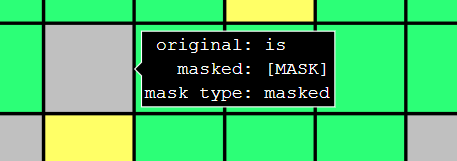

In [ ]:
plot_mlm_batch_plotly(vocab, original_input_ids, masked_input_ids, mask_types, title='Hover the grid to see information.')

### Check with another tokenizer

#### Roberta tokenizer

In [ ]:
tokenizer_name = 'jplu/tf-xlm-roberta-base'
tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
vocab = {v: k for k, v in tokenizer.get_vocab().items()}

mlm_mask_prob = 0.35
mask_type_probs=[0.5, 0.25, 0.25]

prepare_masked_lm_batch = get_masked_lm_fn(
    tokenizer=tokenizer,    
    mlm_mask_prob=mlm_mask_prob,
    mask_type_probs=mask_type_probs
)

In [ ]:
dummy_inputs = tokenizer.batch_encode_plus(dummy_sentence_pairs, max_length=14, padding='max_length', truncation=True)
dummy_inputs = dict(dummy_inputs)
dummy_ds = tf.data.Dataset.from_tensor_slices({'inputs': dummy_inputs}).batch(len(dummy_sentence_pairs))
dummy_batch = next(iter(dummy_ds))
dummy_batch

#### Roberta<a id='visualize-mlm-batch-roberta'></a>

Due to some missing glyphs in the font, we get some tokens rendered as

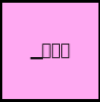

In [ ]:
r = prepare_masked_lm_batch(dummy_batch['inputs'])
original_input_ids, masked_input_ids, mask_types = r['original_input_ids'], r['inputs']['input_ids'], r['mask_types']
plot_mlm_batch(vocab, original_input_ids[:, :], masked_input_ids[:, :], mask_types[:, :], scaling=1.75, plot_original=True)